# Exercice 13) Deep Deterministic Policy Gradients and Proximal Policy Optimization

In this exercise we will investigate two state-of-the-art algorithms: deep deterministic policy gradient (DDPG) and proximal policy optimization (PPO).

We will examine their performance on [Goddard's rocket problem](https://github.com/osannolik/gym-goddard).
This environment comes prepackaged in this notebook's folder, so it can be just imported.

```
First formulated by R. H. Goddard around 1910, this is a classical problem within dynamic optimization and optimal control. The task is simply to find the optimal thrust profile for a vertically ascending rocket in order for it to reach the maximum possible altitude, given that its mass decreases as the fuel is spent and that it is subject to varying drag and gravity.

The state, and the gym's observation space, of the rocket is its vertical position, velocity and mass.

The rocket engine is assumed to be throttled such that the thrust can be continuously controlled between 0 to some maximum limit.
```
![](rocket_spacex.jpg)
(Photo by <a href="https://unsplash.com/@spacex?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">SpaceX</a> on <a href="https://unsplash.com/s/photos/rocket?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>)
  

In order for the full notebook to run through, you will also need the stable-baslines3 package.

```
pip install stable-baselines3[extra]
```

In [1]:
from rocket_env import GoddardEnv
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from stable_baselines3 import PPO, DDPG, A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from copy import deepcopy

## 1) DDPG

Deep Deterministic Policy Gradient (DDPG) combines policy optimization and Q-learning for continous action spaces.
The overall goal is to learn a deterministic policy $\pi$ by using a simultaneously learned Q-value function $\hat{q}$.

If we know the optimal action value function $q^*$ we can find the optimal action by solving 
$u^*(x) = \arg \max_u q^*(x,u)$. 
In continuos action spaces solving it for all possible actions would take an unacceptable amount of time.
Therefore, DDPG learns a Q-function which is differentiable with respect to the action.
We can utilize this to learn a policy $\pi(x)$ which can be used to approximate $\max_u q(x,u) \approx q(x,\pi(x))$ using a differentiable function approximator, which can be trained by minimizing the loss (mean-squared Bellman error (MSBE)):

\begin{align}
     L(w, {\mathcal D}) = \underset{(x,u,r,x',d) \sim {\mathcal D}}{{\mathrm E}}\left[
            \Bigg( \hat{q}(x,u, w) - \left(r + \gamma (1 - d) \max_{a'} \hat{q}_{}(x',u', w) \right) \Bigg)^2
    \right].
\end{align}
    
 Here, $\hat{q}$ is a neural network with its parameters $w$ and the done flag $d$ defines if the environment is terminated.
 
 Using the same parameters during the training which are used to estimate the target $\left(r + \gamma (1 - d) \max_{u'} \hat{q}_{}(x',u', w) \right)$ could lead to instability.
Therefore so called target networks are used to estimate that target. The parameters of the target network $w_\text{target}$ are updated time delayed using the parameters under training $w$ in a low-pass filter manner:
\begin{align}
 w_\text{target} \leftarrow\tau w_\text{target} + (1 - \tau) w
\end{align}
The same idea is used for the policy network parameters. 

Instead of calulating the maximum over all actions in the continous action space, DDPG uses a target policy network $\pi(\theta_\text{target})$ to compute the action which maximizes the target value function $\hat{q}(w_\text{target})$.
 
So, DDPG learns the action value funtion by minimizing the MSBE loss using sotchatic gradient descent (SDG):

\begin{equation}
L(w, {\mathcal D}) = \underset{(x,u,r,x',d) \sim {\mathcal D}}{{\mathrm E}}\left[
    \Bigg( \hat{q}(x,u, w) - \left(r + \gamma (1 - d)  \hat{q}_{}(x',\pi(x', \theta_\text{target}), w_\text{target}) \right) \Bigg)^2
    \right].
\end{equation}   


The overall goal is to find a deterministic policy $\pi(\theta)$ to get the action in a specific state $x$ that maximizes $\hat{q}_{}(x, u, w)$. 
Because of we assume that $\hat{q}_{}(x ,u, w)$ is differentiable with respect to the actions we can perform gradient ascent to improve our policy:

\begin{align}
    \max_{\theta} \underset{s \sim {\mathcal D}}{{\mathrm E}}\left[\hat{q}(x, \pi_{}(x, \theta), w) \right]
\end{align}  
Hints:

- The algorithm uses an experience replay buffer ${\mathcal D}$ to store previous experience. Therefore it is an off-policy algorithm which (policy changes over time while data in replay buffer not till it is filled up).
 

- The exploration / exploitation delammy is solved an action noise is added to the actions drwan from the deterministic policy during training. In our case we will use noise based on the [Ornstein-Uhlenbck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process).

### Task: Implement the PPO clip variant with Pytorch
Write an DDPG algorithm using the algXXX in lecture slides 13!

For a more detailed introduction we refere e.g. to [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/algorithms/ddpg.html).

Execute the following cell to make use of the defined multi layer perceptron and the plot function!

In [63]:
def mlp(sizes, activation, output_activation=nn.Identity):
    """
    Defines a multi layer perceptron using pytorch layers and activation funtions
    """
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def plot_reward_trends(logs):
    repeats = len(logs['envs'])
    fig, axes = plt.subplots(nrows=1, ncols=repeats, figsize=(repeats*8, 4), sharey=True)
    for ax, _env, _model in zip(axes, logs['envs'], logs['models']):
        ax.plot(_env.get_episode_rewards(), label='rewards', color='green')

        ax.set_ylabel('Reward')
        ax.set_xlabel('Episode')
        ax.set_ylim(0, 0.0123)
        ax.axhline(0.0122079818367078, ls='--', color='red', label='optimal')
        ax.legend(loc='lower left')
        ax2 = ax.twinx()
        ax2.plot(_env.get_episode_lengths(), label='ep lengths')
        ax2.legend()
        ax2.set_ylabel('Steps')
    fig.tight_layout()

def test_agent(agent, env):
    """Deterministic test of the agent in the given env"""    
    num_test_epsidoes = 400
    episode_reward = 0
    episode_len = 0
    state = env.reset()
    
    for j in tqdm(range(num_test_epsidoes)):

        episode_len += 1
        #action = agent.decide(torch.as_tensor(state, dtype=torch.float32))
        action = agent.decide(state, deterministic=True)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        env.render()
        state = next_state
        if done:
            state = env.reset()
            break

    print(f'Reward during test: {episode_reward}')
    print('Optimal control: 0.0122')

    env.close()

Execute the following cells to make use of the predefine actor & critic and the replay buffer!


In [3]:
class Actor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation=nn.ReLU, act_limit=1):
        super().__init__()
        pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.pi = mlp(pi_sizes, activation, nn.Sigmoid)
        self.act_limit = act_limit

    def forward(self, state):
        return self.act_limit * self.pi(state)

    def act(self, state):
        with torch.no_grad():
            return self.act_limit * self.pi(state).numpy()
    

class Critic(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation=nn.ReLU):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, state, action):
        # torch.cat concatenates action to state

        q = self.q(torch.cat([state, action], dim=-1))
        return torch.squeeze(q, -1)  # To ensure q has right shape.
    
class ReplayBuffer:

        def __init__(self, obs_dim, action_dim, buffer_size):
            
            self.state_buf = np.zeros((buffer_size, obs_dim), dtype=np.float32)
            self.next_state_buf = np.zeros((buffer_size, obs_dim), dtype=np.float32)
            self.action_buf = np.zeros((buffer_size, action_dim), dtype=np.float32)
            self.reward_buf = np.zeros(buffer_size, dtype=np.float32)
            self.done_buf = np.zeros(buffer_size, dtype=np.float32)
            self.ptr, self.size, self.max_size = 0, 0, buffer_size

        def push(self, state, action, reward, next_state, done):
            
            self.state_buf[self.ptr] = state
            self.next_state_buf[self.ptr] = next_state
            self.action_buf[self.ptr] = action
            self.reward_buf[self.ptr] = reward
            self.done_buf[self.ptr] = done
            self.ptr = (self.ptr + 1) % self.max_size
            self.size = min(self.size + 1, self.max_size)

        def fetch(self, batch_size=32):
            
            idxs = np.random.randint(0, self.size, size=batch_size)
            
            batch = dict(state=self.state_buf[idxs],
                         next_state=self.next_state_buf[idxs],
                         action=self.action_buf[idxs],
                         reward=self.reward_buf[idxs],
                         done=self.done_buf[idxs])
            
            return {k: torch.as_tensor(v, dtype=torch.float32) for k, v in batch.items()}

Here, fill in the following code template to write a DDPG agent!

In [4]:
class DDPG_agent:
    """Reference:
    https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ddpg/ddpg.py
    """    
    
    def __init__(self, env, actor_hidden_size, actor_number_layers, critic_hidden_size, critic_number_layers,
                 buffer_size, actor_lr, critic_lr, gamma, batch_size, learning_starts, tau):#, action_noise):
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.batch_size = batch_size
        self.learning_starts = learning_starts
        self.gamma = gamma
        self.tau = tau

        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space.shape[0]
        

        # define A&C and the replaybuffer        
        self.actor = None
        self.critic = None
        self.replay_buffer = None
        
        ### BEGIN SOLUTION
        self.actor = Actor(obs_dim, act_dim, [actor_hidden_size] * actor_number_layers, nn.ReLU)
        self.critic = Critic(obs_dim, act_dim, [critic_hidden_size] * critic_number_layers, nn.ReLU)
        self.replay_buffer = ReplayBuffer(obs_dim, act_dim, buffer_size)
        ### END SOLUTION
        
        # defines target networks
        self.actor_target = deepcopy(self.actor)
        self.critic_target = deepcopy(self.critic)
        
        # Uses Adam optimizer (see to ex12 for more explanation)
        self.actor_optimizer = Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=critic_lr)

        # define action noise space for clipping
        self.action_space_high = env.action_space.high
        self.action_space_low = env.action_space.low

    def q_loss(self, data):
        ### BEGIN SOLUTION
        
        state, action, rerwad, next_state, done = data['state'], data['action'], data['reward'], data['next_state'], data['done']
            
        # Gradient descent for Q-function
        self.critic_optimizer.zero_grad()
        q = self.critic.forward(state, action)
        with torch.no_grad():
            q_pi_targ = self.critic_target.forward(next_state, self.actor_target.forward(next_state))
            backup = rerwad + self.gamma * (1 - done) * q_pi_targ
            
        # MSE loss against Bellman backup
        return ((q - backup) ** 2).mean()
    
        ### END SOLUTION
    
    def pi_loss(self, data):
        """
        Calulate the loss for a gradient ascent(!) step
        """
        ### BEGIN SOLUTION
        
        state = data['state']
            
        self.actor_optimizer.zero_grad()
        return -self.critic.forward(state, self.actor.forward(state)).mean()

        ### END SOLUTION
        
    
    def deliberate(self, number_updates_per_step):
        """
        Fetches number_updates_per_step-times from replay_buffer, computes targets and calculates losses to 
        update the q-function using gradient descent and the policy function using gradient ascent
        In the end updates the target networks
        """

        for _ in range(number_updates_per_step):
            ### BEGIN SOLUTION
        
            data = self.replay_buffer.fetch(self.batch_size)
            
            # Gradient descent for Q-function
            loss_q = self.q_loss(data)
            loss_q.backward()
            self.critic_optimizer.step()

            # Freeze Q-network so you don't waste computational effort
            # computing gradients for it during the policy learning step.
            for p in self.critic.parameters():
                p.requires_grad = False

            # Gradient ascent step for pi.
            loss_pi = self.pi_loss(data)
            loss_pi.backward()
            self.actor_optimizer.step()

            # Unfreeze Q-network so you can optimize it at next DDPG step.
            for p in self.critic.parameters():
                p.requires_grad = True

            # Finally, update target networks by polyak averaging.
            with torch.no_grad():
                # update Critc-target
                for p, p_targ in zip(self.critic.parameters(), self.critic_target.parameters()):
                    # uses in-place operations "mul_", "add_" to update target
                    # params, as opposed to "mul" and "add", which would make new tensors.
                    p_targ.data.mul_(1 - self.tau)
                    p_targ.data.add_((self.tau) * p.data)

                # update Actor-target
                for p, p_targ in zip(self.actor.parameters(), self.actor_target.parameters()):
                    # uses in-place operations "mul_", "add_" to update target
                    # params, as opposed to "mul" and "add", which would make new tensors.
                    p_targ.data.mul_(1 - self.tau)
                    p_targ.data.add_((self.tau) * p.data)
                           
            ### END SOLUTION
            
    def decide(self, state, deterministic=False, noise_scale=0.1):
        """
        Returns action as nd-array depending on the state, adds scaled noise 
        and clipps the action depending on the actionspace
        """
        
        ### BEGIN SOLUTION
        action = self.actor.act(torch.as_tensor(state, dtype=torch.float32))
        
        if deterministic:
            return np.clip(action, self.action_space_low, self.action_space_high)
        else:
            return np.clip(action + 0.1 * np.random.randn(1), self.action_space_low, self.action_space_high)
        ### END SOLUTION
        
                           

Run the following cell to train your agent

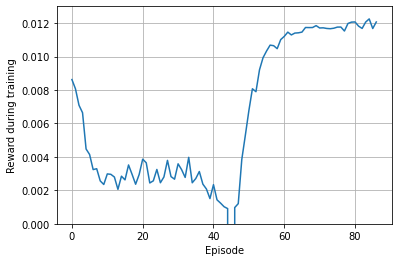

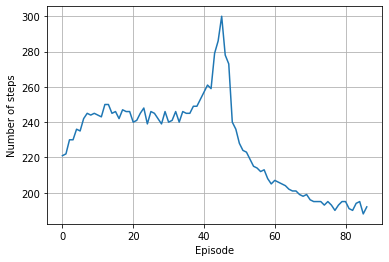

In [9]:
total_timesteps = 20000
env = GoddardEnv()

myDDPG_agent = DDPG_agent(env=env, actor_hidden_size=8, actor_number_layers=1,
                       critic_hidden_size=8, critic_number_layers=1, buffer_size=int(1e6),
                       actor_lr=1e-4, critic_lr=1e-4, gamma=0.999, batch_size=256, learning_starts=100, tau=0.005)


number_updates_per_step = 0
episode_reward = 0
episode_len = 0
rewards = []
episode_len_vec = []


state = env.reset()


for j in tqdm(range(total_timesteps)):

    episode_len += 1
    number_updates_per_step += 1


    action = myDDPG_agent.decide(state)
    next_state, reward, done, _ = env.step(action)
    episode_reward += reward

    myDDPG_agent.replay_buffer.push(state, action, reward, next_state, done)
    #env.render()

    state = next_state
    
            

    if done:
        myDDPG_agent.deliberate(number_updates_per_step)
        state = env.reset()
        rewards.append(episode_reward)
        episode_len_vec.append(episode_len)
        episode_reward = 0
        episode_len = 0
        number_updates_per_step = 0


plt.plot(rewards)

plt.ylim([0,0.013])
plt.xlabel('Episode')
plt.ylabel('Reward during training')
plt.grid()
plt.show()

plt.plot(episode_len_vec)
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Number of steps')
plt.show()

Use the follwoing cell to test your agent on the env using deterministic actions

In [61]:
env = GoddardEnv()
test_agent(myDDPG_agent, env)

NameError: name 'myDDPG_agent' is not defined

### Demo: StableBaselines3 usage

Alternatively, in the real world, you would use readily available Python packages such as [stable-baselines3](https://github.com/DLR-RM/stable-baselines3) for employment of state-of-the-art algorithms.
In what follows below, the DDPG algorithm as utilized by stable-baselines3 is showcased.

In [12]:
total_timesteps = int(20e3)


class Pbar(BaseCallback):
    def __init__(self):
        super().__init__()
        self.pbar = tqdm(desc='Training', total=total_timesteps)

    def _on_rollout_end(self) -> None:
        """This event is triggered before updating the policy."""
        # self.pbar.update(self.)

    def _on_step(self) -> bool:
        self.pbar.update()
        return True
    
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[8], vf=[8])])

repeats = 5
logs = {'envs': [], 'models': []}
for _ in range(repeats):
    
    env = Monitor(GoddardEnv())
    
    #n_actions = env.action_space.shape[-1]
    #noise_var = 4
    #noise_theta = 25  # stiffness of OU
    #action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), theta=noise_theta * np.ones(n_actions),
    #                                        sigma=noise_var * np.ones(n_actions))
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
    
    policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[8] * 1, qf=[8] * 1))
    model = DDPG("MlpPolicy", env, policy_kwargs=policy_kwargs, batch_size=256, device='cpu',
             learning_rate=1e-4, gamma=0.999)
    model.learn(total_timesteps=total_timesteps, callback=Pbar())
    logs['envs'] += [env]
    logs['models'] += [model]

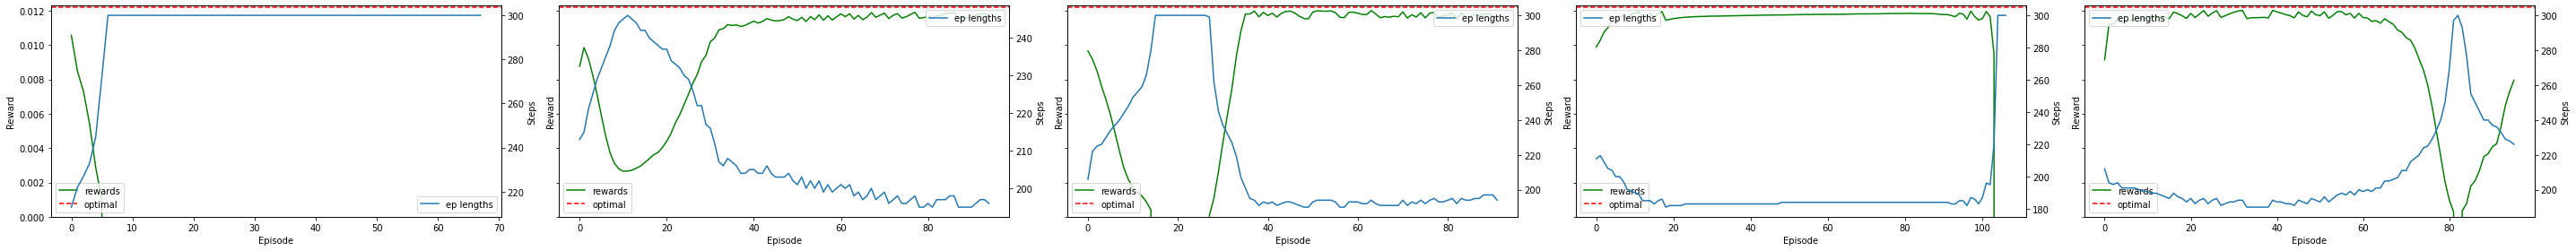

In [13]:
plot_reward_trends(logs)

Use the following cell to execute the last trained agent

In [14]:
n_episodes = 1
#model = DDPG("MlpPolicy", env, policy_kwargs=policy_kwargs, batch_size=64, device='cpu', learning_starts=1280,
 #            learning_rate=1e-3)
max_steps_per_episode = 500
tst_logs = {'rewards': []}
for ep in range(n_episodes):
    state = env.reset()
    done = np.zeros(1, dtype=np.bool)
    cum_rew = 0
    k = 0
    while not np.all(done) and k < max_steps_per_episode:
        action, _ = model.predict(state, deterministic=True) # env.action_space.sample()#
        state, reward, done, info = env.step(action)
        env.render()
        cum_rew += reward
        k += 1

    tst_logs['rewards'].append(cum_rew)
rewards = np.array(tst_logs['rewards']).ravel()
env.close()

<ipython-input-14-6c7524635bbc>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  done = np.zeros(1, dtype=np.bool)


## 2) PPO

The [original paper from 2017](https://arxiv.org/abs/1707.06347) for the PPO came up with an idea to combine A2C (having multiple workers) and TRPO (using a trust region to improve the actor).
The PPO algorithm achieves this by hard clipping gradients in order to ensure that new policies won't be too far away from old ones.

In contrast to DDPG, PPO is an on-policy algorithm. In order to still apply mini-batch training, there is a so-called roll-out-buffer that is filled up with the current policy, on whose base a gradient ascent update would be done.

There are [two variants on the PPO algorithm](https://spinningup.openai.com/en/latest/algorithms/ppo.html), from which we will implement the clip variant.

The actor (policy) update is computed according to

\begin{align}
\theta_{k+1} &= \arg \max_{\theta} \underset{\langle x,u \rangle \sim \pi_{\theta_k}}{{\mathbb E}}\left[\mathcal L(X,U,\theta_k, \theta)\right], \\
\mathcal L(x,u,\theta_k,\theta) &= \min\left(
\frac{\pi_{\theta}(u|x)}{\pi_{\theta_k}(u|x)}  A^{\pi_{\theta_k}}(x,u), \;\;
\text{clip}\left(\frac{\pi_{\theta}(u|x)}{\pi_{\theta_k}(u|x)}, 1 - \epsilon, 1+\epsilon \right) A^{\pi_{\theta_k}}(x, u)
\right),
\end{align}
where the expectation operator denotes the empirical average across the roll-out-buffer, $\theta$ the possible next weights of the actor, $\epsilon$ denotes the threshold within the next update is allowed, and $\mathcal L$ the long-term return.

On the opposite side, the critic's weights $\omega_k$ are updated through the plain stochastic mini-batch gradient descent on the mean squared error $\mathcal C$ between immediately seen rewards $r_{k+1}$ and corresponding estimated value $v_{\phi_k}(x_k)$ across the roll-out-buffer:
\begin{align}
\phi_{k+1} &\leftarrow \omega_k - \eta \nabla\mathcal C(X,R_{k+1},\omega_k), \\
\mathcal C(x,r_{k+1}, \omega_k) &= \left(v_{\omega_k} (x_k)- r_{k+1}\right)^2
\end{align}

### Task: Implement the PPO clip variant with Pytorch
Fill in the below code to run the PPO-clip variant on the rocket environment.

For simplicity, do not contemplate a vectorized environment for synchronous training (like in A2C or A3C).

In [83]:
class StochActor(nn.Module):
    """This stochastic actor learns a Gaussian distribution. While the mean value 
    is learnt by a full-fledged MLP, the standard deviation is denoted by a
    single trainable weight. With Pytorch's distribution package, probabilities 
    given a certain distribution and an action can be calculated."""
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # The standard deviation is just one trainable weight
        self.log_std = torch.nn.Parameter(
                        torch.as_tensor(
                            -.5 * np.ones(action_dim, dtype=np.float32)))
        # the mean value is estimated by a full MLP
        self.mu_net = mlp(list(state_dim) + [8] + list(action_dim), nn.Tanh, nn.Sigmoid)
        
    def _distribution(self, state):
        return torch.distributions.normal.Normal(
                self.mu_net(state), torch.exp(self.log_std))
    
    def forward(self, state, action=None):
        pi = self._distribution(state)
        # if action is None, logp_a will be, too
        if action is None:
            logp_a = None
        else:
            logp_a = pi.log_prob(action).sum(axis=-1)
        return pi, logp_a

class PPOAgent:
    """Reference:
    https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/ppo/ppo.py
    """
    
    class RolloutBuffer:
        def __init__(self, size, action_dim, state_dim):
            self.action_buf = np.zeros((size, action_dim[0]), dtype=np.float32)
            self.state_buf = np.zeros((size, state_dim[0]), dtype=np.float32)
            self.rew_buf = np.zeros(size+1, dtype=np.float32)
            self.val_buf = np.zeros(size+1, dtype=np.float32)
            self.logp_buf = np.zeros(size, dtype=np.float32)
            self.i = 0
            self.max_size = size
            
        def push(self, state, action, reward, value, logp):
            """Append a sample to the buffer"""
            ### BEGIN SOLUTION
            self.state_buf[self.i] = state
            self.action_buf[self.i] = action
            self.rew_buf[self.i] = reward
            self.val_buf[self.i] = value
            self.logp_buf[self.i] = logp
            self.i += 1
            ### END SOLUTION
            
        def fetch(self, last_val=None, gamma=0.999):
            """Get all data from the rollout buffer.
            Returns a dictionary for state, action, rewards-to-go, advantages, and logp values.
            Entries might be of different length across multiple calls to this function as episodes
            potentially have different lengths. Rewards-to-go and advantages need to be computed from 
            rewards, values, and gamma"""
            ### BEGIN SOLUTION
            if last_val is not None:
                self.rew_buf[self.i] = last_val
                self.val_buf[self.i] = last_val
            rewards = self.rew_buf[:self.i+1]
            values = self.val_buf[:self.i+1]
            
            # Advantage calculaton            
            advantages = rewards[:-1] + gamma * values[1:] - values[:-1]
            weights = gamma ** np.arange(advantages.size)
            advantages = np.cumsum(weights * advantages[::-1])[::-1]
            
            # reward
            rewards_to_go = np.cumsum(weights * (gamma*rewards[:-1][::-1]))[::-1]
            
            # normalize advantages
            advantages = (advantages - advantages.mean()) / np.std(advantages)
            
            data =  {'state': self.state_buf[:self.i],
                     'action': self.action_buf[:self.i],
                     'rewards_to_go': rewards_to_go.copy(),  # make stride positive
                     'advantages': advantages, 
                     'logp': self.logp_buf[:self.i]}
            self.i = 0
            
            return {k: torch.as_tensor(v, dtype=torch.float32) for k, v in data.items()}
            ### END SOLUTION
    
    def __init__(self, buffer_size, env):
        self.buf = self.RolloutBuffer(buffer_size, action_dim=env.action_space.shape,
                                 state_dim=env.observation_space.shape)
        # use the below attributes for the actor-critic agent
        self.actor = None
        self.critic = None
        self.n_epochs = 8
        self.clip_ratio = 0.1
        ### BEGIN SOLUTION
        
        self.actor = StochActor(action_dim=env.action_space.shape, state_dim=env.observation_space.shape)
        self.critic = mlp(list(env.observation_space.shape) + [8, 1], nn.Tanh, nn.Tanh)
        self.pi_opt = Adam(self.actor.parameters(), lr=1e-3)
        self.v_opt = Adam(self.critic.parameters(), lr=1e-3)
        
        ### END SOLUTION

    
    def v_loss(self, data):
        ### BEGIN SOLUTION
        state, rewards_to_go = data['state'], data['rewards_to_go']
        return ((self.critic(state).squeeze(-1) - rewards_to_go)**2).mean()
        ### END SOLUTION
    
    def pi_loss(self, data):
        ### BEGIN SOLUTION
        state, action, advantage, logp_old = [data[k] for k 
                                              in ('state', 'action', 'advantages', 'logp')]
        
        pi, logp = self.actor(state, action)
        ratio = torch.exp(logp - logp_old)
        clip_adv = torch.clamp(ratio, 1-self.clip_ratio, 1+self.clip_ratio) * advantage
        loss_pi = -(torch.min(ratio * advantage, clip_adv)).mean()
        
        return loss_pi
        ### END SOLUTION
    
    def deliberate(self, last_value=None):
        """Fetch the rollout buffer for all samples.
        Train the actor and critic for n_epochs by computing the pi and v
        loss iteratively.
        The rewards and values buffer needs a zero appended for terminal states,
        or the critic's estimate appended in case of intermediate states 
        that result from timeout. This is denoted by last_value."""
        ### BEGIN SOLUTION
        batch = self.buf.fetch(last_value)
        loss_pi_old = self.pi_loss(batch).item()
        loss_v_old = self.v_loss(batch).item()
        
        # update policy n_epoch times
        for _ in range(self.n_epochs):
            self.pi_opt.zero_grad()
            loss_pi = self.pi_loss(batch)
            loss_pi.backward()
            self.pi_opt.step()
        
            self.v_opt.zero_grad()
            loss_v = self.v_loss(batch)
            loss_v.backward()
            self.v_opt.step()
        
        ### END SOLUTION
    
    def decide(self, state, deterministic=False):
        """Receive a state as torch tensor and return a tuple of numpy ndarrays
        in the form (action, value, log-probability-of-action-under-pi)"""
        ### BEGIN SOLUTION
        state = torch.as_tensor(state, dtype=torch.float32)
        with torch.no_grad():
            pi = self.actor._distribution(state)
            if deterministic:
                return pi.mean
            else:
                a = pi.sample()
            logp_a = pi.log_prob(a).sum(axis=-1)
            v = self.critic(state)
        return a.numpy(), v.numpy(), logp_a.numpy()
        ### END SOLUTION
        
    

In [84]:
# main training loop

n_episodes = 250
max_steps_per_episode = 500
train_logs = {'rewards': [], 'envs': [], 'models': []}
repeats = 4
for rep in range(repeats):
    env = Monitor(GoddardEnv())
    agent = PPOAgent(max_steps_per_episode, env)

    for ep in tqdm(range(n_episodes), desc='Training'):
        state = env.reset()
        done = False
        cum_rew = 0
        k = 0
        while not done and k < max_steps_per_episode:
            action, value, logp_a = agent.decide(state) 
            next_state, reward, done, info = env.step(action)

            # track experience
            agent.buf.push(state, action, reward, value, logp_a)

            cum_rew += reward
            state = next_state
            k += 1

        # if episode finished with done signal, the long term value should be 0
        #  for this terminal state
        if done:
            last_value = None
        else:
            _, last_value, _ = self.decide(state)
        agent.deliberate(last_value)
        #train_logs['rewards'].append(cum_rew)
    #rewards = np.array(train_logs['rewards']).ravel()
    train_logs['envs'] += [env]
    train_logs['models'] += [agent]
    env.close()


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

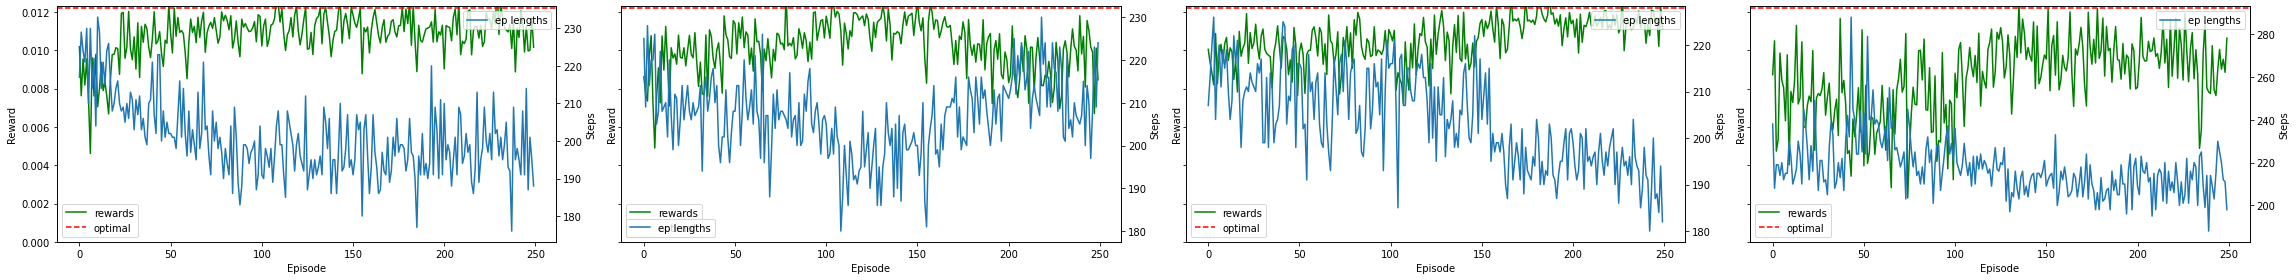

In [85]:
plot_reward_trends(train_logs)

In [86]:
test_agent(agent, env)

  0%|          | 0/400 [00:00<?, ?it/s]

TypeError: type Tensor doesn't define __round__ method

In [87]:
env.close()

### Demo: StableBaselines3 usage

Alternatively, in the real world, you would use readily available Python packages such as [stable-baselines3](https://github.com/DLR-RM/stable-baselines3) for employment of state-of-the-art algorithms.
In what follows below, the PPO algorithm as utilized by stable-baselines3 is showcased.

In [ ]:
class Pbar(BaseCallback):
    """This is a callback that helps monitoring the training progress"""
    def __init__(self, total, n_rollout_steps):
        super().__init__()
        self.n_steps = n_rollout_steps
        self.pbar = tqdm(desc='Training', total=total)
        
    def _on_rollout_end(self) -> None:
        """This event is triggered before updating the policy."""
        self.pbar.update(self.n_steps)
    
    def _on_step(self) -> bool:
        return True

    
policy_kwargs = dict(activation_fn=torch.nn.Sigmoid, net_arch=[dict(pi=[8], vf=[8])])

n_steps = 256  # an episode takes around ~250 steps
total_timesteps = n_steps*250  # steps_per_episode * episodes

repeats = 5  # repeat experiment x times to assess scatter through random init
logs = {'envs': [], 'models': []}
for _ in range(repeats):
    
    env = Monitor(GoddardEnv())
    model = PPO('MlpPolicy', env, n_steps=n_steps, n_epochs=10,  verbose=0, device='cpu', learning_rate=1e-4, batch_size=n_steps, policy_kwargs=policy_kwargs,
               clip_range=0.1, clip_range_vf=0.1, gamma=0.999)
    model = model.learn(total_timesteps=total_timesteps, callback=Pbar(total_timesteps, n_steps))
    logs['envs'] += [env]
    logs['models'] += [model]

In [ ]:
plot_reward_trends(logs)

Obviously, the chosen architecture and hyper parameters do well often, but can also fail abruptly. 
What might be the reason for these failures?

In [ ]:
n_episodes = 1
max_steps_per_episode = 500
tst_logs = {'rewards': []}

for ep in range(n_episodes):
    state = env.reset()
    done = False
    cum_rew = 0
    k = 0
    while not done and k < max_steps_per_episode:
        action, _ = model.predict(state, deterministic=True) #
        state, reward, done, info = env.step(action)
        env.render()
        cum_rew += reward
        k += 1

    tst_logs['rewards'].append(cum_rew)
rewards = np.array(tst_logs['rewards']).ravel()
env.close()

In [ ]:
print(f'Mean reward ± std.dev: {rewards.mean():.6f} ± {rewards.std()}, best: {rewards.max()}')

In [ ]:
fig = plt.figure(figsize=(10, 5))

plt.scatter(np.random.randn(rewards.size), rewards, label='Cum. Reward')
# source: https://github.com/osannolik/gym-goddard/blob/master/gym_goddard/envs/optimal_control.ipynb
plt.axhline(0.0122079818367078, ls='--', color='red', label='optimal')
# own experiments
plt.axhline(0.00995, ls=':', color='blue', label='avg. with random actions')
plt.axhline(0.01148, ls='-.', color='blue', label='best with random actions')
plt.xlabel('Runs')
plt.ylabel('Reached height')
plt.ylim(0, None)
plt.xticks([])
plt.title('Comparison between PPO performance and some baselines')
_ = plt.legend()
